### XGBoost

Dimensionality Reduction / Feature Selection

In [1]:
#importing libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
import pickle
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
from scipy.stats import uniform, randint
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, matthews_corrcoef, cohen_kappa_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#opening pickle file of augmented added data
with open('/content/drive/Shareddrives/SignLanguageData/combined_augmented_data_v3.pkl','rb') as f:
    X_train,y_train,X_test,y_test = pickle.load(f)

In [4]:
#letters
letters = ['A','B','C','D','E','F','G','H','I','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y']
#numbers 
numbers = sorted(list(np.unique(y_train.astype(int))))
#dictionary of labels 
labels = dict(zip(numbers,letters))

From the initial modeling results for this dataset, the normal (not reduced to images of edges) re-scaled using standardization produced the best results. As a result, standardized normal images will be used for the remainder of this notebook.

In [ ]:
#standardized data 
#using sklearn standard scaler model and fitting on training data 
sc = StandardScaler().fit(X_train.reshape(X_train.shape[0],-1))
X_train = sc.transform(X_train.reshape(X_train.shape[0],-1))
X_test = sc.transform(X_test.reshape(X_test.shape[0],-1))

Dimensionality reduction is an important step in the Data Science pipeline because it reduces the complexity of the model by reducing the number of input features. This results in a decreased likelihood for the model to overfit on the training data. Additionally, removing noise and unimportant/redundant features can lead to better performing models. Lastly, reducing dimensionality will decrease the computational and memory requirements to train and use the model. 

Linear Discriminant Analysis is a linear supervised learning algorithm used for classification tasks by projecting the data to a lower dimensionality that maximizes the separation between classes. This is achieved by finding the vectors in the feature space that best separates the different classes of the data and minimizes the variance of the data within each class. 

In [ ]:
#define sklearn LDA object 
lda = LinearDiscriminantAnalysis()
#fit on training data 
lda.fit(X_train,y_train)

LinearDiscriminantAnalysis()

In [ ]:
#fit on training data and transform
X_train_lda = lda.transform(X_train)
X_test_lda = lda.transform(X_test)

Plotting components 1 and 2 from the LDA computation, it is observed that it does reasonably well at separating certain letters from others. For example, X and Y is separated well from the other letters using the first two linear discriminants. The other letters likely require more components to result in a clearer separation between the classes.

Hyperparameter tuning is an important step in modeling, where the values chosen for a model's hyperparameters can drastically change the performance of the model. Grid Search CV and Randomized Grid Search are methods to find the optimal values that results in the best performing model. 

Grud Search is an exhaustive search algorithm that tries every combination of each set of hyperparameters, and determines which results in the best model. Randomized Grid Search randomly chooses combinations of hyperarameters, which results in less computational requirments but does not guarantee the best performing model is found. However, with a sufficiently high n_iter value, it is likely a close to best performing model is found. 

For this investigation, randomized search will be used. 

#### Modeling with XGboost
XGBoost (Extreme Gradient Boosting) is a powerful and widely used gradient boosting algorithm that is particularly well-suited for dealing with large datasets. It is based on the concept of ensemble learning, where multiple weak learners (decision trees) are combined to create a strong learner that can make accurate predictions. XGBoost is known for its speed, scalability, and ability to handle missing values and outliers. It has become a popular choice in various machine learning competitions and is widely used in industry for a wide range of applications including image and text classification, fraud detection, and recommendation systems.

Important hyperparameters for XGBoost: learning rate, max depth, subsample, colsample bytree. These will be defined in a dictionary as an input for Randomized Search CV. 

In [ ]:
def evaluate_model(y_true, y_pred, labels):
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy}")
    
    # Classification report
    print("Classification report:")
    print(classification_report(y_true, y_pred, target_names=labels))
    
    # Matthews Correlation Coefficient (MCC)
    mcc = matthews_corrcoef(y_true, y_pred)
    print(f"MCC: {mcc}")
    
    # Cohen's Kappa
    kappa = cohen_kappa_score(y_true, y_pred)
    print(f"Cohen's Kappa: {kappa}")
    
    # Confusion Matrix
    cm = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=labels)
    fig, ax = plt.subplots(figsize=(16,14))  # set figure size
    cm.plot(cmap='BuPu', ax=ax)  # set color map and axis
    plt.title("Confusion Matrix")
    plt.show()

In [ ]:
# define the hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.05],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 2, 3, 4],
    'subsample': [0.4, 0.6],
    'colsample_bytree': [0.4, 0.6],
    'gamma': [0],
    'reg_alpha': [0],
    'reg_lambda': [1]
}

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.fit_transform(y_test)

In [ ]:
# Create an XGBoost classifier object
xgb = XGBClassifier()

# Create a RandomizedSearchCV object
xgb_search = RandomizedSearchCV(estimator=xgb, 
                                param_distributions=param_grid,
                                cv=3, 
                                random_state=42, 
                                verbose=3)

In [ ]:
# Fit the RandomizedSearchCV object to the transformed data
xgb_search.fit(X_train_lda, y_train_encoded)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


KeyboardInterrupt: ignored

In [ ]:
from xgboost import XGBClassifier

# Create an XGBoost classifier object with fixed hyperparameters
xgb = XGBClassifier(learning_rate=0.01, 
                    max_depth=6, 
                    min_child_weight=5, 
                    subsample=0.6, 
                    colsample_bytree=0.6, 
                    gamma=0, 
                    reg_alpha=1, 
                    reg_lambda=5)

# Fit the XGBoost classifier object to the transformed data
xgb.fit(X_train_lda, y_train_encoded)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [ ]:
# applying XGB on Training data
y_pred_xgb_train = xgb.predict(X_train_lda)

Accuracy: 0.6526588963758878
Classification report:
              precision    recall  f1-score   support

           A       0.66      0.71      0.68      4504
           B       0.73      0.70      0.71      4040
           C       0.86      0.79      0.83      4576
           D       0.62      0.55      0.58      4784
           E       0.68      0.68      0.68      3828
           F       0.65      0.64      0.65      4816
           G       0.72      0.72      0.72      4360
           H       0.72      0.66      0.69      4052
           I       0.59      0.69      0.64      4648
           K       0.64      0.64      0.64      4456
           L       0.62      0.74      0.68      4964
           M       0.63      0.55      0.59      4220
           N       0.62      0.50      0.55      4604
           O       0.76      0.77      0.77      4784
           P       0.78      0.80      0.79      4352
           Q       0.73      0.83      0.78      5116
           R       0.46      

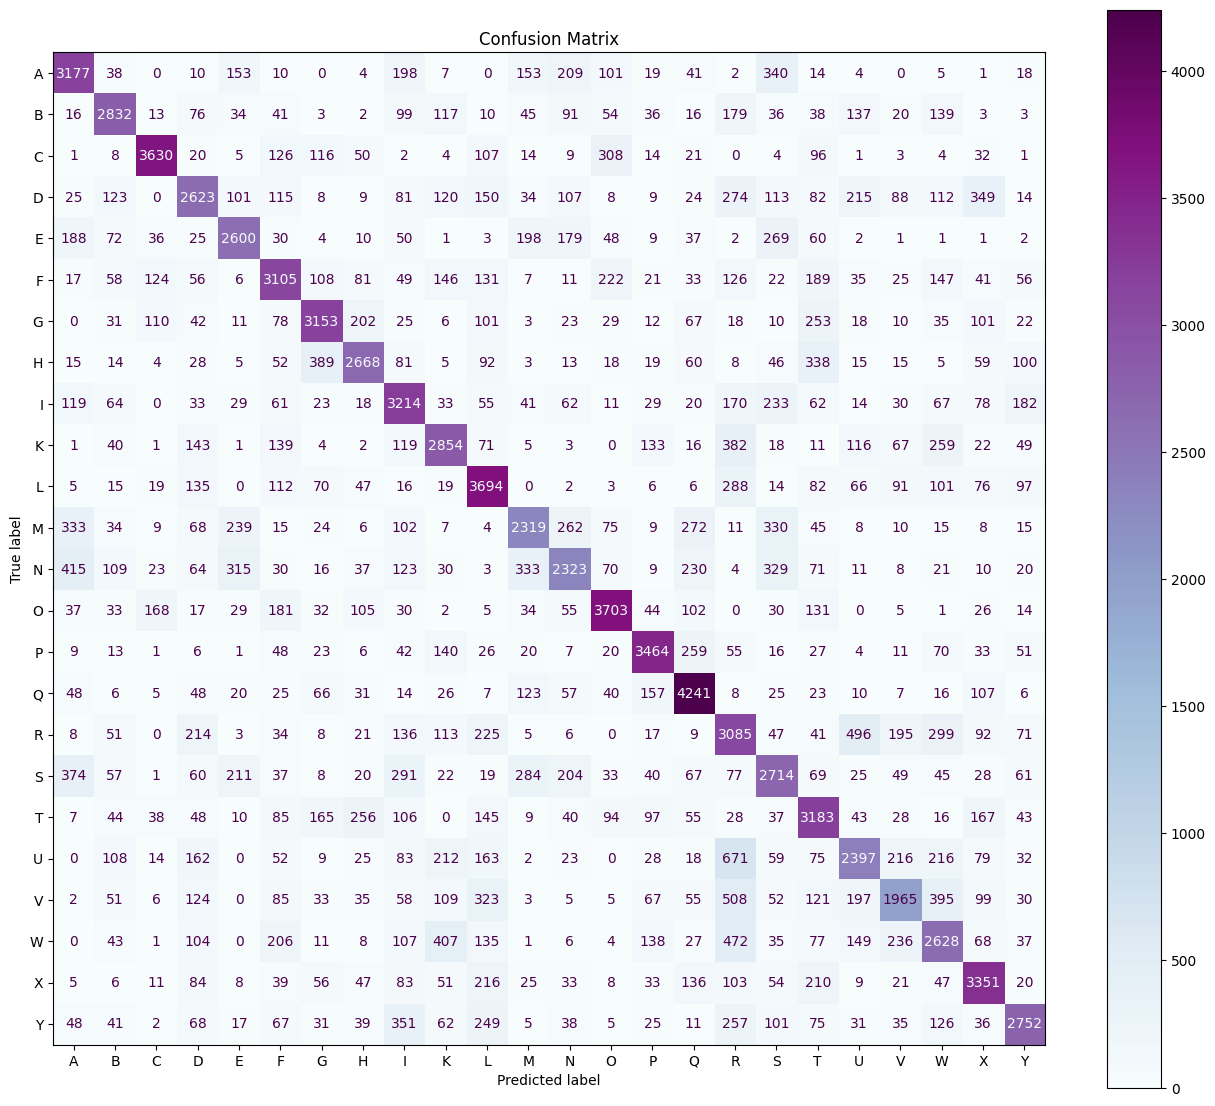

In [ ]:
evaluate_model(y_train_encoded, y_pred_xgb_train, letters)

In [ ]:
# applying xgb on Test data
y_pred_xgb_test = xgb.predict(X_test_lda)

Accuracy: 0.4844534300055772
Classification report:
              precision    recall  f1-score   support

           A       0.48      0.68      0.56      1324
           B       0.71      0.54      0.61      1728
           C       0.82      0.69      0.75      1240
           D       0.41      0.46      0.43       980
           E       0.71      0.56      0.63      1992
           F       0.46      0.50      0.48       988
           G       0.52      0.50      0.51      1392
           H       0.79      0.52      0.62      1744
           I       0.40      0.46      0.43      1152
           K       0.43      0.42      0.42      1324
           L       0.50      0.80      0.61       836
           M       0.51      0.37      0.43      1576
           N       0.35      0.29      0.32      1164
           O       0.64      0.61      0.63       984
           P       0.81      0.66      0.73      1388
           Q       0.39      0.73      0.51       656
           R       0.12      

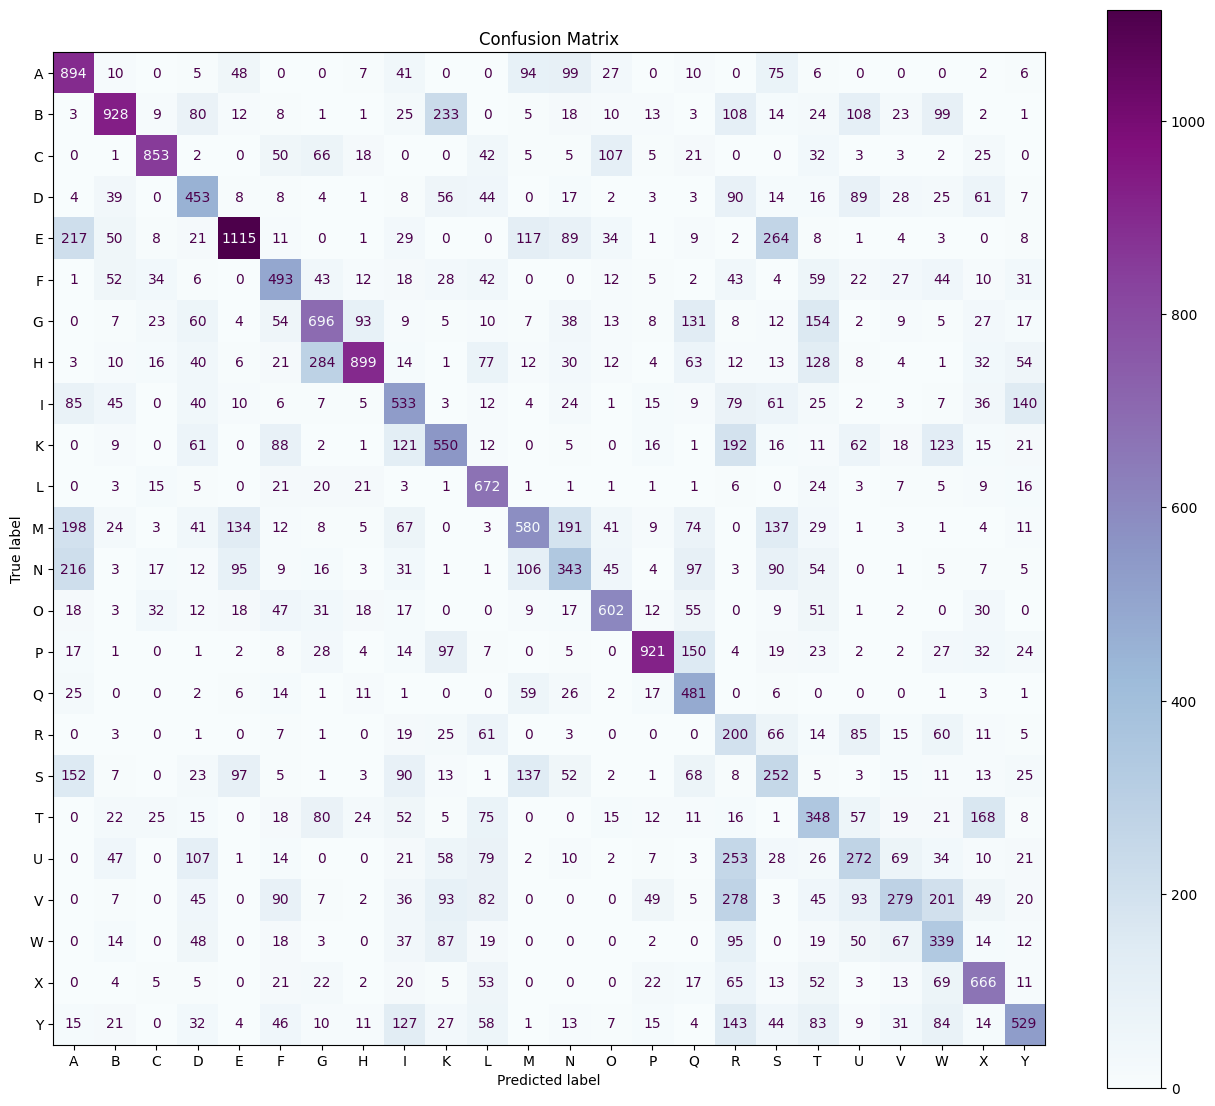

In [ ]:
evaluate_model(y_test_encoded, y_pred_xgb_test, letters)

### Loading Feature data

In [6]:
# Load the augmented data from the file
data = np.load('/content/drive/Shareddrives/SignLanguageData/combined_features_pca_lda.npz')
X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']

In [7]:
#printing shapes 
print(f'X_train Shape: {X_train.shape}')
print(f'y_train Shape: {y_train.shape}')
print(f'X_test Shape: {X_test.shape}')
print(f'y_test Shape: {y_test.shape}')

X_train Shape: (109820, 53)
y_train Shape: (109820,)
X_test Shape: (28688, 53)
y_test Shape: (28688,)


In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.fit_transform(y_test)

In [9]:
from xgboost import XGBClassifier

# Create an XGBoost classifier object with fixed hyperparameters
xgb = XGBClassifier(learning_rate=0.01, 
                    max_depth=6, 
                    min_child_weight=5, 
                    subsample=0.6, 
                    colsample_bytree=0.6, 
                    gamma=0, 
                    reg_alpha=1, 
                    reg_lambda=5)

# Fit the XGBoost classifier object to the transformed data
xgb.fit(X_train, y_train_encoded)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [11]:
# applying Logistic regression and predicting on train
y_pred_xgb_train = xgb.predict(X_train)
# testing logistic regression on test data
y_pred_xgb_test = xgb.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test_encoded, y_pred_xgb_test)}")
print(f" Train Accuracy: {accuracy_score(y_train_encoded, y_pred_xgb_train)}")

Test Accuracy: 0.6421151701059676
 Train Accuracy: 0.8215716627208158
